In [1]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Download census-income dataset

In [2]:
out = 'data/train.csv'

In [3]:
train = pd.read_csv(out)

In [4]:
train.loss = np.log(train.loss + 1)

In [5]:
mean = train.loss.mean()
std = train.loss.std()

In [6]:
train.loss = (train.loss - mean) / std

In [7]:
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

train.drop(['Set', 'id'], axis=1, inplace=True)
train.fillna(-1, inplace=True)

In [8]:
from lib.data import preprocess

In [9]:
split_indices = dict(
    train=train_indices,
    valid=valid_indices,
    test=test_indices
)

In [10]:
data = preprocess(train, target='loss', split_indices=split_indices, encoder='cat_encoder',
                  normalize=True, quantile_transform=True, experiment_type='regression',
                  quantile_noise=1e-3)
# data = preprocess(train, target='loss', split_indices=split_indices, encoder='label_encoder',
#                   normalize=False, quantile_transform=False, experiment_type='regression',
#                   quantile_noise=1e-3)

['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


In [11]:
from lib.model import NodeRegressor

In [12]:
model = NodeRegressor(input_dim=data['X_train'].shape[1], output_dim=1, layer_dim=256, num_layers=1, tree_dim=3)
# cat_idxs=data['cat_idxs'], cat_dims=data['cat_dims'], cat_emb_dim=2)

Device used : cuda


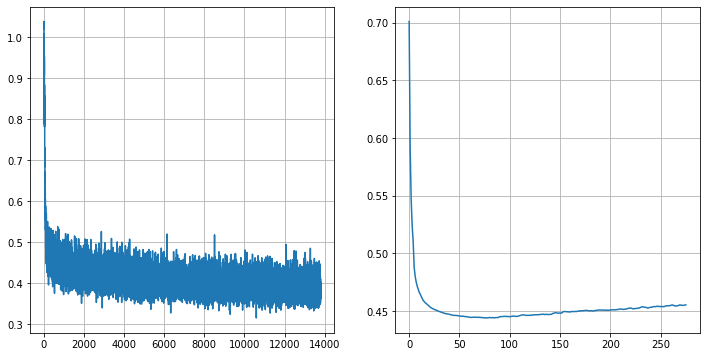

Loss 0.37940
Val mse: 0.45547
BREAK. There is no improvment for 10000 steps
Best step:  3800
Best Val mse: 0.44409
Loaded logs/debug/checkpoint_best.pth


In [13]:
model.fit(data['X_train'], data['y_train'],
          X_valid=data['X_valid'], y_valid=data['y_valid'],
          plot=True)

In [14]:
model.trainer.load_checkpoint(tag='best')

Loaded logs/debug/checkpoint_best.pth


Trainer(
  (model): Node(
    (layers): Sequential(
      (0): DenseBlock(
        (0): ODST(in_features=130, num_trees=256, depth=6, tree_dim=3, flatten_output=True)
      )
      (1): Lambda()
    )
  )
)

In [15]:
preds = model.predict(data['X_test'])

In [16]:
data['y_test']

array([ 1.91316011, -0.87255018, -0.77993838, ...,  0.58466244,
       -0.13780934, -1.17343355])

In [17]:
preds

array([[ 1.597785  ],
       [-0.9481742 ],
       [-1.0552362 ],
       ...,
       [-0.9469695 ],
       [-0.18752508],
       [-0.2484134 ]], dtype=float32)

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
mean_absolute_error(np.exp(data['y_test']*std + mean) - 1, np.exp(preds.flatten()*std + mean) - 1)

1136.9572821697682